---
title: "GPA Analysis"
author: "Brandon Scott"
date: "2022-12-24"
categories: [analysis, bayesian]
draft: false
toc: true
format:
    html:
        code-fold: true
jupyter: python3
---

# Analysis of relationship between GPA and # study hours

## Introduction

The hope of this analysis is to demonstratet that there is a quantifiable relationship between GPA and study hours. We recognize that the collected data was self reported and therefore can be dishonest. Nonetheless, our goal is to still find a way to quantify a relationship between GPA and study hours to:
<ol>
    <li>Gather inference to determine how GPA changes based on increase study time</li>
    <li>Predict what a student's GPA would be based on study time</li>
</ol>

Data for this analysis can be found [here](https://www.kaggle.com/datasets/joebeachcapital/gpa-study-hours)

## Setup Analysis

We begin our analysis by importing the following libraries to create data visualizations as well as properly format and filter our data.

In [1]:
#Import libraries
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### ONLY RUN ONCE ###
#Download dataset
#od.download("https://www.kaggle.com/datasets/joebeachcapital/gpa-study-hours")

100%|█████████████████████████████████| 658/658 [00:00<00:00, 21.0kB/s]

In [3]:
#Create dataframe from file
df = pd.read_csv("kaggle_datasets//gpa-study-hours/gpa_study_hours.csv")

In [4]:
#Check dataframe
df.head()

,gpa,study_hours
0,4.00,10.0
1,3.80,25.0
2,3.93,45.0
3,3.40,10.0
4,3.20,4.0


The head result indicates that the data has been read in correctly. In the next section, we will begin to clean the data.

## Data Cleaning

We will begin our data cleaning by getting some basic summary statistics from the dataframe.

In [5]:
#Describe dataset
df.describe()

,gpa,study_hours
count,193.000000,193.000000
mean,3.586166,17.476684
std,0.285482,11.408980
min,2.600000,2.000000
25%,3.400000,10.000000
50%,3.620000,15.000000
75%,3.800000,20.000000
max,4.300000,69.000000


The resulting dataframe shows that we have 193 rows of data where on average the gpa is 3.58 with a standard deviation of .28. Average study hours show 17.47 and standard deviation of 11.4, meaning we have a large spread in the distribution of study hours but not too much in gpa. From the summary statistics, we can easily see that the max value is invalid as the scale we are using for this analysis is 0-4. We will eliminate any rows that fall outside of this range.

In [6]:
#Check datatypes
df.dtypes

gpa            float64
study_hours    float64
dtype: object

Checking the datatypes of each of the columns, we see that each is of type float. This confirms that all rows in each column are of the same datatype and, in theory, we do not need to clean up any corrupted data/poorly entered data.

In [7]:
#Check for null values
df.isnull().sum()

gpa            0
study_hours    0
dtype: int64

In addition, checking for nulls, we see there are none so we do not need to do anything with those. In the next code chunk, we will eliminate erroneous gpa entries.

In [8]:
#Convert outlier GPA (erroneous entries) to 4.0
df = df.assign(gpa = lambda x: np.where(x.gpa > 4, 4, x.gpa))

## EDA

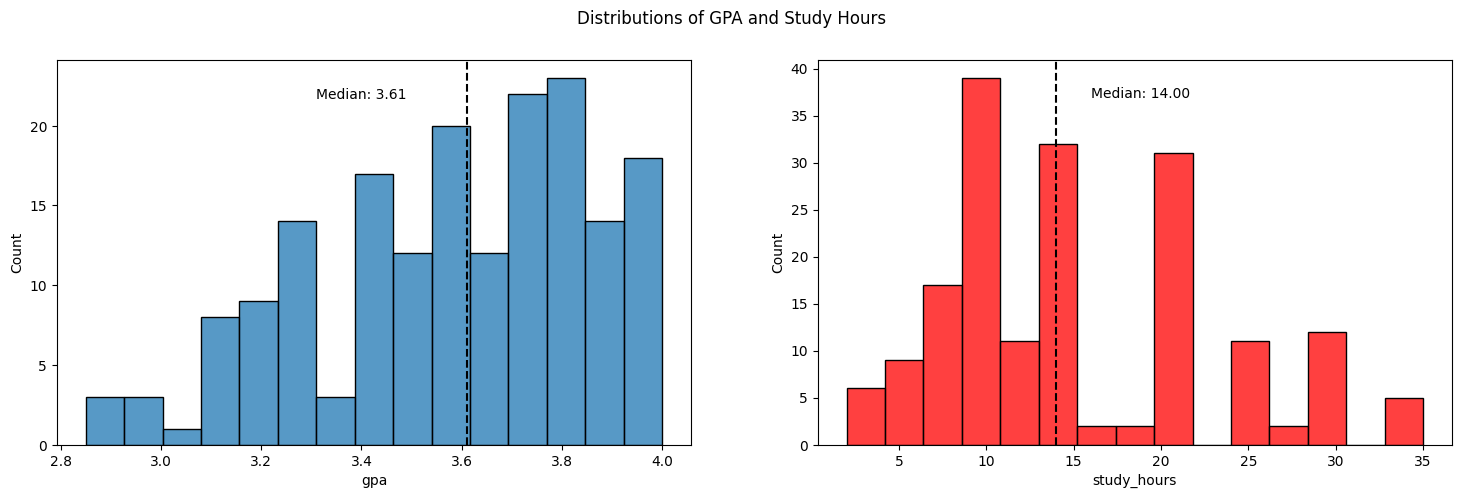

In [25]:
#| label: fig-dist-1
#| fig-cap: "Distributions of GPA and Study Hours"

# Check distributios of gpa and study hours
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 5))
sns.histplot(x="gpa", data=df, ax=ax1, bins=15)
ax1.axvline(df.gpa.median(), color="black", linestyle="dashed")
ax1.text(df.gpa.median() - 0.3, ax1.get_ylim()[1] * 0.9, f"Median: {df.gpa.median():.2f}")

sns.histplot(x="study_hours", data=df, ax=ax2, color="red", bins=15)
ax2.axvline(df.study_hours.median(), color="black", linestyle="dashed")
ax2.text(df.study_hours.median() + 2, ax2.get_ylim()[1] * 0.9, f"Median: {df.study_hours.median():.2f}")

fig.suptitle("Distributions of GPA and Study Hours");

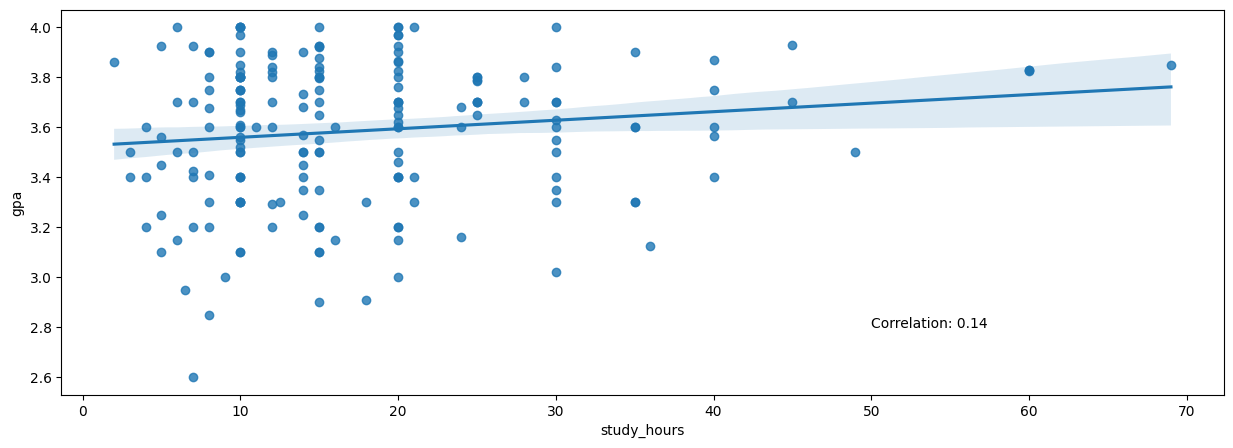

In [10]:
#| label: fig-scatterplot-1
#| fig-cap: "Scatterplot of GPA by Study Hours"

#Scatterplot of gpa and study hours
plt.figure(figsize=(15,5))
sns.regplot(x='study_hours', y='gpa', data=df)
corr_coef = np.corrcoef(df.study_hours, df.gpa)[0][1]
plt.text(50, 2.8, f"Correlation: {corr_coef:.2f}");

In [11]:
#Identify outliers
def find_outliers(x, column_name):
    q1 = x[column_name].quantile(.25)
    q3 = x[column_name].quantile(.75)
    iqr = q3 - q1
    lower = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)
    outliers = x[(x[column_name] < lower) | (x[column_name] > upper)]
    
    return outliers
    

In [12]:
#Find outliers for gpa
find_outliers(df, "gpa")

,gpa,study_hours
108,2.6,7.0


In [16]:
#Find outliers for study hours
find_outliers(df, "study_hours")["study_hours"].min()

36.0

In [18]:
#Remove outliers from dataset
df = df.query("gpa > 2.6 and study_hours < 36")

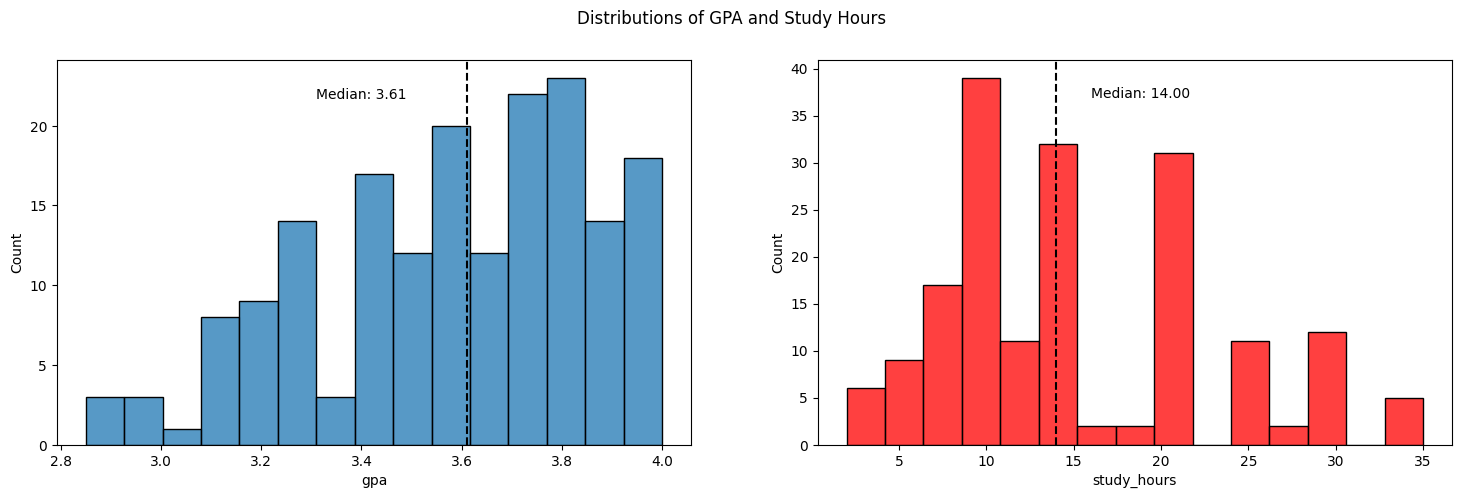

In [19]:
#| label: fig-dist-2
#| fig-cap: "Distributions of GPA and Study Hours (w/o outliers)"

#Revisualize distributions without outliers
# Check distributios of gpa and study hours
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 5))
sns.histplot(x="gpa", data=df, ax=ax1, bins=15)
ax1.axvline(df.gpa.median(), color="black", linestyle="dashed")
ax1.text(df.gpa.median() - 0.3, ax1.get_ylim()[1] * 0.9, f"Median: {df.gpa.median():.2f}")

sns.histplot(x="study_hours", data=df, ax=ax2, color="red", bins=15)
ax2.axvline(df.study_hours.median(), color="black", linestyle="dashed")
ax2.text(df.study_hours.median() + 2, ax2.get_ylim()[1] * 0.9, f"Median: {df.study_hours.median():.2f}")

fig.suptitle("Distributions of GPA and Study Hours");

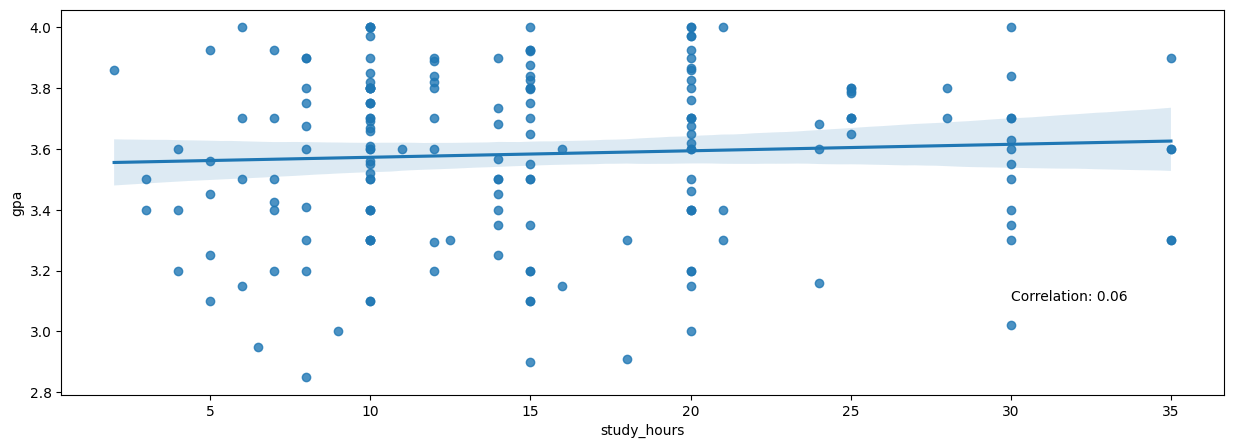

In [23]:
#| label: fig-scatterplot-2
#| fig-cap: "Scatterplot of GPA by Study Hours"

#Revisit scatterplot
plt.figure(figsize=(15,5))
sns.regplot(x='study_hours', y='gpa', data=df)
corr_coef = np.corrcoef(df.study_hours, df.gpa)[0][1]
plt.text(30, 3.1, f"Correlation: {corr_coef:.2f}");